Instead of using the dataset provided here, lets use the one available at github (it is available as 5 sec files there).Here
is the link: https://github.com/karolpiczak/ESC-50

In [1]:
import librosa
import librosa.display
from fastai import *
from fastai.vision import *
import os
import shutil
import matplotlib.pyplot as plt

In [2]:
raw_data_path = Path("../input/esc50-github")

The data is made available in a single folder. Here we will first segregate it in 5 folds as instructed.
It is very important to segregate the data the way it is instructed because of potential data leak between train and valid set (some of the clips are generated by splitting up files into several shorter clips (e.g. taking 15 seconds of guitar, and splitting it into three 5 second clips). If those files aren't kept together in one fold, and some end up in training and others in the validation set, our model may learn features we aren't interested in, like background noise, or something particular to the microphone that was used, to identify the label).

In [3]:
df = pd.read_csv(raw_data_path/'meta/esc50.csv')
fold1 = [f for f in df.loc[df['fold'] == 1].filename]
fold2 = [f for f in df.loc[df['fold'] == 2].filename]
fold3 = [f for f in df.loc[df['fold'] == 3].filename]
fold4 = [f for f in df.loc[df['fold'] == 4].filename]
fold5 = [f for f in df.loc[df['fold'] == 5].filename]
path=Path('/kaggle/working')
os.mkdir(path/'1')
os.mkdir(path/'2')
os.mkdir(path/'3')
os.mkdir(path/'4')
os.mkdir(path/'5')
for file in fold1:
    shutil.copy(raw_data_path/'audio'/file,path/'1')
for file in fold2:
    shutil.copy(raw_data_path/'audio'/file,path/'2')
for file in fold3:
    shutil.copy(raw_data_path/'audio'/file,path/'3')
for file in fold4:
    shutil.copy(raw_data_path/'audio'/file,path/'4')
for file in fold5:
    shutil.copy(raw_data_path/'audio'/file,path/'5')

In [4]:
labels_dict = dict(zip(df['target'],df['category']))
print(labels_dict)

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


Computed spectograms directory corresponding to the folds.

In [5]:
os.mkdir(path/'spec1')
os.mkdir(path/'spec2')
os.mkdir(path/'spec3')
os.mkdir(path/'spec4')
os.mkdir(path/'spec5')

Each fold is going to have a valid and train set. Spectograms corresponding to a particular fold will lie in its own valid directory while its train directory will contain the valid data of all other folds. So spec1 directory has valid and train folders in it, valid folder has spectograms corresponding to fold 1 wav files while train folder of spec1 will have valid data of all other remaining folds. So forth for all other folds.

In [6]:
for i in range(1,6):
    os.mkdir(path/Path('spec'+str(i))/'train')
    os.mkdir(path/Path('spec'+str(i))/'valid')
    for label in labels_dict.values():       
        os.mkdir(path/Path('spec'+str(i))/'train'/label)
        os.mkdir(path/Path('spec'+str(i))/'valid'/label)

Below we compute spectograms corresponding to all folds and save them in the corresponding valid folders of corresponding folds. The spectograms will be of size (299,299).

I should point out here that some of the parameters (hop_length and n_mels) used to generate spectogram are passed odd values. They are generally powers of 2 for faster computation. I chose these numbers because I wanted the spectograms to be of dimension (299,299) so that I wouldnt need to resize spectograms at training time and thus lose valuable information. I never tried some other dimension or even rectangular dimensions so it is possible to even further increase the accuracy by fine tuning these parameters.

In [7]:
for i in range(1,6):
    for file in os.listdir(path/str(i)):
        label=labels_dict[int(file[:-4].split("-")[-1])]                
        fig = plt.figure(figsize=[0.96,0.96])
        ax = fig.add_subplot(111)        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        samples, sample_rate = librosa.load(path/str(i)/file,sr=None)
        sg = librosa.feature.melspectrogram(y=samples,sr=44100,n_fft=2048,hop_length=739,n_mels=299,fmin=0.0)
        db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
        librosa.display.specshow(db_spec, fmax=8000)
        file = os.path.join(path,'spec'+str(i),'valid',label,file[:-4]+'.png')
        plt.savefig(file,dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

Below one transfers valid data from 4 folds to train folder of remaining fold.

In [8]:
for i in range(1,6):
    source_folds = [j for j in range(1,6) if i != j]
    for fold in source_folds:
        for label in labels_dict.values():
            for file in os.listdir(path/Path('spec'+str(fold))/'valid'/label):
                shutil.copy(path/Path('spec'+str(fold))/'valid'/label/file,path/Path('spec'+str(i))/'train'/label)

Data is all set up. Now display spectograms along with their labels.

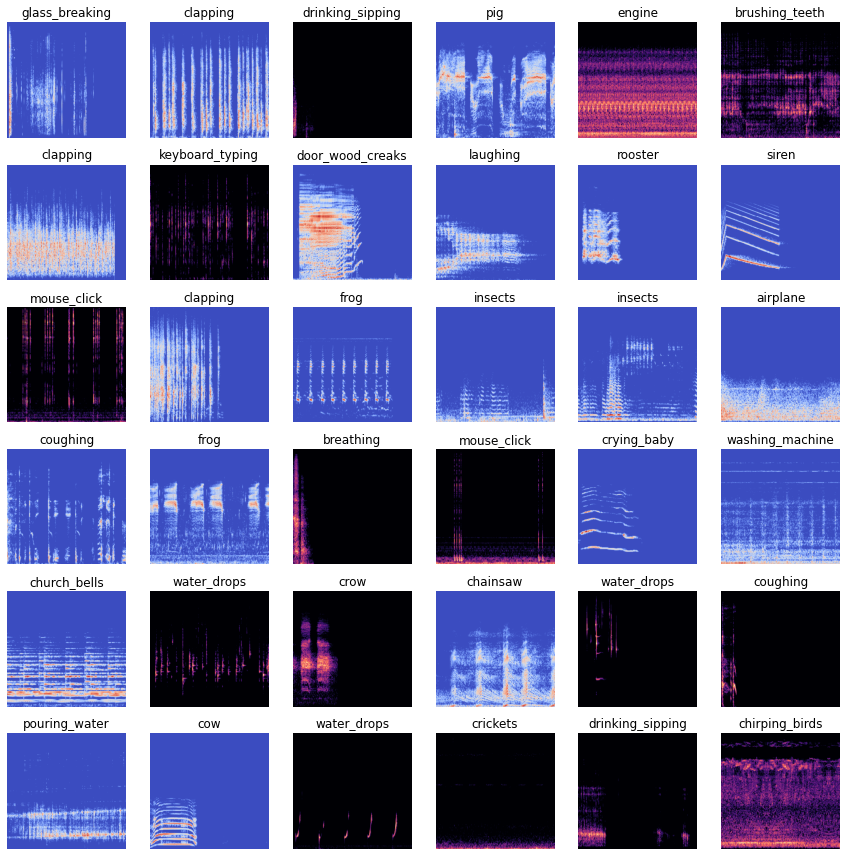

In [9]:
train = path/'spec1'
valid = path/'spec1'
data = ImageDataBunch.from_folder(path/'spec1',ds_tfms=None,num_workers=1)
data.show_batch(rows=6,figsize=(12,12))

The **fold** argument here specifies which fold is going to be the valid set, all other folds are going to be the train set.

In [10]:
def valid_fold(fold):
    train = path/Path('spec'+str(fold))
    valid = path/Path('spec'+str(fold))
    data = ImageDataBunch.from_folder(path/Path('spec'+str(fold)),ds_tfms=None,num_workers=1)
    learn = cnn_learner(data, models.resnet50, metrics=error_rate).mixup()
    learn.fit_one_cycle(2,2e-03)
    learn.unfreeze()
    learn.fit_one_cycle(35,1e-03)
    learn.recorder.plot_losses()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,4.240574,2.315274,0.600000,00:19
1,3.218976,1.812286,0.500000,00:15


epoch,train_loss,valid_loss,error_rate,time
0,2.391108,1.620708,0.420000,00:19
1,2.119287,1.418990,0.397500,00:17
2,1.935016,1.540490,0.430000,00:18
3,1.886298,1.790653,0.455000,00:17
4,1.873907,2.398700,0.522500,00:17
5,1.927330,2.823745,0.600000,00:18
6,1.935020,3.728951,0.635000,00:18
7,1.863023,1.634377,0.415000,00:17
8,1.835668,2.080235,0.492500,00:18
9,1.809409,2.399861,0.527500,00:18


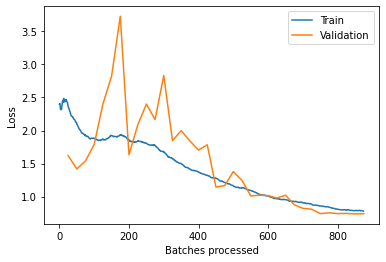

In [11]:
valid_fold(1)

epoch,train_loss,valid_loss,error_rate,time
0,4.253948,2.407115,0.625000,00:14
1,3.253721,1.765247,0.490000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,2.382107,1.606563,0.462500,00:17
1,2.158789,1.330495,0.367500,00:18
2,2.003397,1.500176,0.390000,00:18
3,1.911773,1.591356,0.422500,00:17
4,1.962411,1.940447,0.475000,00:18
5,1.982200,2.387571,0.565000,00:18
6,1.990428,2.408035,0.540000,00:18
7,1.941082,2.213372,0.532500,00:17
8,1.912492,2.781878,0.570000,00:18
9,1.837018,2.131029,0.525000,00:18


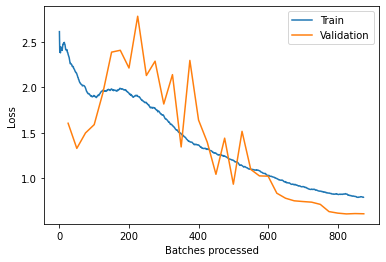

In [12]:
valid_fold(2)

epoch,train_loss,valid_loss,error_rate,time
0,4.210479,2.350222,0.632500,00:14
1,3.240052,1.727470,0.485000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,2.380306,1.660084,0.452500,00:17
1,2.172245,1.504398,0.410000,00:17
2,1.991265,1.377463,0.377500,00:17
3,1.869425,1.699716,0.425000,00:17
4,1.905090,2.048759,0.517500,00:17
5,1.939782,2.783399,0.552500,00:18
6,1.916377,2.335670,0.512500,00:17
7,1.871944,1.941830,0.487500,00:17
8,1.834464,2.025014,0.507500,00:18
9,1.782489,2.255040,0.497500,00:17


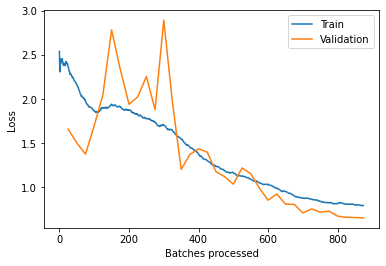

In [13]:
valid_fold(3)

epoch,train_loss,valid_loss,error_rate,time
0,4.345183,2.464532,0.627500,00:14
1,3.299449,1.550244,0.445000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,2.403676,1.397537,0.405000,00:17
1,2.170331,1.229475,0.370000,00:17
2,1.974862,1.247233,0.367500,00:17
3,1.940882,1.750486,0.452500,00:17
4,1.888697,1.770371,0.452500,00:17
5,1.930722,1.726658,0.430000,00:18
6,1.951877,3.122043,0.565000,00:17
7,1.946999,2.828652,0.550000,00:17
8,1.911409,2.356721,0.482500,00:17
9,1.883762,1.466315,0.420000,00:17


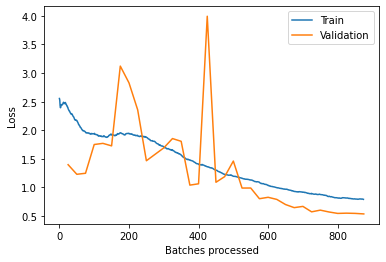

In [14]:
valid_fold(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.179259,2.435416,0.620000,00:14
1,3.179732,1.920911,0.500000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,2.314014,1.718784,0.472500,00:17
1,2.123654,1.601524,0.410000,00:17
2,1.966807,1.470401,0.392500,00:18
3,1.883930,2.005971,0.440000,00:17
4,1.881832,3.270039,0.570000,00:17
5,1.948980,2.856991,0.590000,00:17
6,1.994874,2.793945,0.617500,00:17
7,1.945196,2.945969,0.542500,00:17
8,1.921809,2.770092,0.580000,00:17
9,1.827173,2.293837,0.477500,00:17


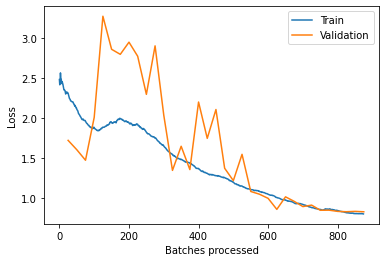

In [15]:
valid_fold(5)

In [16]:
1-((0.21+0.1625+0.18+0.175+0.215)/5)

0.8115

For 4 folds, valid_loss < train_loss so we can even train it further and might gain some more accuracy but those gains will not be very high (according to what I have observed after multiple runs).